In [13]:
import pandas as pd
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter

import tensorflow as tf
import tensorflow.keras as keras

In [2]:
class_names = ['buildings', 'forest', 'glacier', 'mountain',
               'sea', 'street']
train_dir = "seg_train/seg_train"
test_dir = "seg_test/seg_test"

train_count = []
for c in class_names:
    print("Total training images for", c, ":", len(os.listdir(train_dir + "/" + c)))
    train_count.append(len(os.listdir(train_dir + "/" + c)))

print("")
test_count = []
for c in class_names:
    print("Total testing images for", c, ":", len(os.listdir(test_dir + "/" + c)))
    test_count.append(len(os.listdir(test_dir + "/" + c)))
print('')
for i in range(len(train_count)):
    tot = train_count[i] + test_count[i]
    print("Percentage training for", class_names[i], ":", train_count[i]/tot)
    print('Total images for', class_names[i], ':', train_count[i] + test_count[i])
    print('')
    
print('Total training images:', sum(train_count))
print('Total testing images:', sum(test_count))

Total training images for buildings : 2191
Total training images for forest : 2271
Total training images for glacier : 2404
Total training images for mountain : 2512
Total training images for sea : 2274
Total training images for street : 2382

Total testing images for buildings : 437
Total testing images for forest : 474
Total testing images for glacier : 553
Total testing images for mountain : 525
Total testing images for sea : 510
Total testing images for street : 501

Percentage training for buildings : 0.8337138508371386
Total images for buildings : 2628

Percentage training for forest : 0.8273224043715847
Total images for forest : 2745

Percentage training for glacier : 0.8129861345958742
Total images for glacier : 2957

Percentage training for mountain : 0.8271320381955878
Total images for mountain : 3037

Percentage training for sea : 0.8168103448275862
Total images for sea : 2784

Percentage training for street : 0.826222684703434
Total images for street : 2883

Total training 

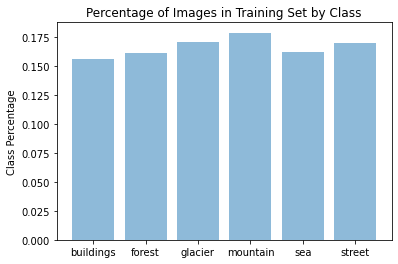

In [3]:
train_perc = [x / sum(train_count)for x in train_count]
y_pos = np.arange(len(class_names))

plt.bar(y_pos, train_perc, align='center', alpha=0.5)
plt.xticks(y_pos, class_names)
plt.ylabel('Class Percentage')
plt.title('Percentage of Images in Training Set by Class')

plt.show()

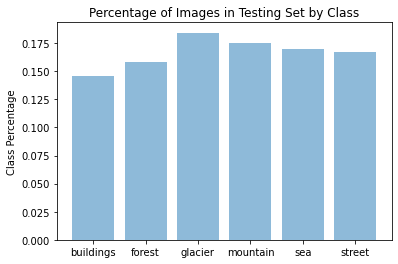

In [4]:
test_perc = [x / sum(test_count)for x in test_count]
y_pos = np.arange(len(class_names))

plt.bar(y_pos, test_perc, align='center', alpha=0.5)
plt.xticks(y_pos, class_names)
plt.ylabel('Class Percentage')
plt.title('Percentage of Images in Testing Set by Class')

plt.show()

In [5]:
# get training data
image_sizes = {}
image_types = {}
for index, c in enumerate(class_names):
    for dr in os.listdir(train_dir + "/" + c):
        im = Image.open(train_dir + "/" + c + "/" + dr)
        if str(im.size) in image_sizes.keys():
            image_sizes[str(im.size)] = image_sizes[str(im.size)] + 1
        else:
            image_sizes[str(im.size)] = 1
        if str(im.mode) in image_types.keys():
            image_types[str(im.mode)] = image_types[str(im.mode)] + 1
        else:
            image_types[str(im.mode)] = 1
len(image_sizes)

31

In [16]:
print(image_sizes)
print("\n")
print(image_types)
# looking at this, we can tell that almost all images are 150x150 so that shall be the size of the image
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

k = Counter(image_sizes)
  
# Finding 3 highest values
high = k.most_common(3) 

print("\n3 highest values in image sizes")
  
for i in high:
    print(i[0]," :",i[1]," ")

{'(150, 150)': 13986, '(150, 124)': 1, '(150, 113)': 7, '(150, 108)': 2, '(150, 133)': 1, '(150, 115)': 1, '(150, 135)': 3, '(150, 136)': 2, '(150, 110)': 1, '(150, 105)': 1, '(150, 111)': 3, '(150, 120)': 1, '(150, 149)': 1, '(150, 143)': 2, '(150, 146)': 2, '(150, 134)': 2, '(150, 142)': 2, '(150, 123)': 2, '(150, 119)': 1, '(150, 102)': 1, '(150, 76)': 1, '(150, 97)': 1, '(150, 144)': 2, '(150, 103)': 1, '(150, 100)': 1, '(150, 141)': 1, '(150, 145)': 1, '(150, 81)': 1, '(150, 147)': 1, '(150, 131)': 1, '(150, 140)': 1}


{'RGB': 14034}

3 highest values in image sizes
(150, 150)  : 13986  
(150, 113)  : 7  
(150, 135)  : 3  


In [17]:
# no longer needed, using generators instead
training_images = []
training_targets = []

for index, c in enumerate(class_names):
    for dr in os.listdir(train_dir + "/" + c):
        im = Image.open(train_dir + "/" + c + "/" + dr)
        # resize image
        im = im.resize((IMAGE_HEIGHT, IMAGE_WIDTH))
        im = np.asarray(im).astype('float32')
        # normalize image
        im /= 255
        # add image and target to respective arrays
        training_images.append(im)
        training_targets.append(index)

print(len(training_images))
print(len(training_targets))

# get validation data
testing_images = []
testing_targets = []

for index, c in enumerate(class_names):
    for dr in os.listdir(test_dir + "/" + c):
        im = Image.open(test_dir + "/" + c + "/" + dr)
        # resize image
        im = im.resize((IMAGE_HEIGHT, IMAGE_WIDTH))
        im = np.asarray(im).astype('float32')
        # normalize image
        im /= 255
        # add image and target to respective arrays
        testing_images.append(im)
        testing_targets.append(index)

print(len(testing_images))
print(len(testing_targets))

14034
14034
3000
3000


In [18]:
# create generators for getting data
training_datagen = ImageDataGenerator(rescale=1./255)
testing_datagen = ImageDataGenerator(rescale=1./255)
training_generator = training_datagen.flow_from_directory(train_dir,
                            target_size=(150, 150), batch_size=20, class_mode="categorical")
testing_generator = testing_datagen.flow_from_directory(test_dir, target_size=(150, 150),
                            batch_size=20, class_mode="categorical")

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [21]:
drop_rate = 0.5
model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(3, 3), activation='relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),
        #tf.keras.layers.Dropout(drop_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), loss='categorical_hinge', 
              metrics=['acc', keras.metrics.Precision(), keras.metrics.Recall()])

In [22]:
# train the model
history = model.fit(training_generator,
                    epochs=20,
                   validation_data=testing_generator)

Epoch 1/20
702/702 [==============================] - 41s 59ms/step - loss: 0.8662 - acc: 0.5130 - precision: 0.6691 - recall: 0.3150 - val_loss: 0.7201 - val_acc: 0.6333 - val_precision: 0.6580 - val_recall: 0.6130
Epoch 2/20
702/702 [==============================] - 40s 56ms/step - loss: 0.6548 - acc: 0.6701 - precision: 0.6862 - recall: 0.6580 - val_loss: 0.6579 - val_acc: 0.6683 - val_precision: 0.6755 - val_recall: 0.6557
Epoch 3/20
702/702 [==============================] - 37s 53ms/step - loss: 0.5546 - acc: 0.7235 - precision: 0.7317 - recall: 0.7176 - val_loss: 0.5907 - val_acc: 0.7083 - val_precision: 0.7119 - val_recall: 0.7017
Epoch 4/20
702/702 [==============================] - 36s 51ms/step - loss: 0.4988 - acc: 0.7517 - precision: 0.7568 - recall: 0.7478 - val_loss: 0.5376 - val_acc: 0.7377 - val_precision: 0.7432 - val_recall: 0.7323
Epoch 5/20
702/702 [==============================] - 38s 54ms/step - loss: 0.4429 - acc: 0.7808 - precision: 0.7845 - recall: 0.7778 - 

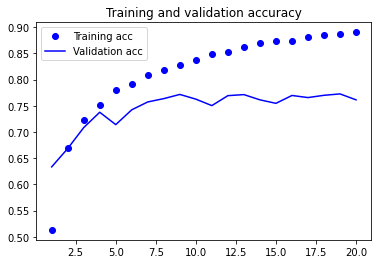

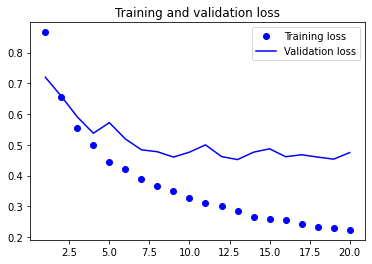

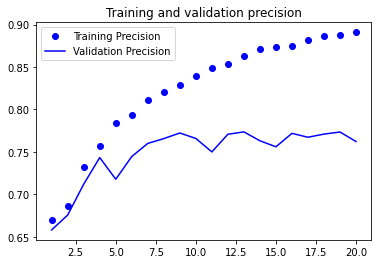

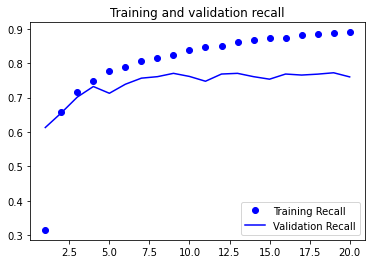

In [23]:
# graph post training data for validation and training against eachother
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
prec = history.history['precision']
val_prec = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']
epochs = range(1, len(acc) + 1)

# accuracy graph
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# loss graph
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# precision graph
plt.plot(epochs, prec, 'bo', label='Training Precision')
plt.plot(epochs, val_prec, 'b', label='Validation Precision')
plt.title('Training and validation precision')
plt.legend()
plt.show()

# recall graph
plt.plot(epochs, recall, 'bo', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

In [16]:
# save model for further training
model.save("models/")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/assets
